In [3]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA

In [1]:
get_pricing(
   "AAPL",
    fields='close_price', #modify to price, open_price, high, low or volume to change the field
    start_date='2019-05-09', #customize your pricing date range
    end_date = '2019-05-09',
    frequency='daily', #change to daily for daily pricing
)

# matplotlib is installed for easy plotting


2019-05-09 00:00:00+00:00    200.72
Freq: C, Name: Equity(24 [AAPL]), dtype: float64

In [6]:
from quantopian.pipeline.data.sentdex import sentiment
from quantopian.pipeline.filters.morningstar import Q500US
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline import factors, filters, classifiers, Pipeline
from quantopian.pipeline.data import Fundamentals  
from quantopian.pipeline.factors.fundamentals import MarketCap
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.research import run_pipeline

In [7]:
import alphalens

In [9]:
def make_pipeline():
   
    factor = Fundamentals.market_cap.latest  
    universe = Q500US()
       
    market_mask = factor.top(100, mask = universe)
    
    ret_30 = factors.Returns(
        window_length=30,
        mask=market_mask
    )
    
    stand_ret_30 = -(ret_30.zscore())
    low_returns = stand_ret_30.percentile_between(0,10)
    high_returns = stand_ret_30.percentile_between(90,100)
    
    
    securities_to_trade = (low_returns | high_returns)
    
    pipe = Pipeline(  
        columns={ 
            'ret_30': ret_30, 
        },  
        screen=securities_to_trade  
    )  
    return pipe 

In [10]:
result = run_pipeline(make_pipeline(), start_date='4-09-2018', end_date='4-09-2019')

In [11]:
assets = result.index.levels[1]

In [12]:
pricing_data = get_pricing(assets, start_date='3-09-2018', end_date='5-09-2019',fields='close_price')

In [13]:
from alphalens.utils import get_clean_factor_and_forward_returns

merged_data = get_clean_factor_and_forward_returns(
    factor=result['ret_30'], 
    prices=pricing_data, 
    quantiles = 2,
    periods = (1,15,30)
)

Dropped 3.6% entries from factor data: 3.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.455052,0.109593,-0.109815,0.068525,2440,50.010248
2,-0.051476,0.510823,0.133843,0.068491,2439,49.989752


Returns Analysis


,1D,15D,30D
Ann. alpha,-0.043,-0.039,-0.059
beta,-0.142,-0.060,-0.049
Mean Period Wise Return Top Quantile (bps),-1.770,-1.273,-1.705
Mean Period Wise Return Bottom Quantile (bps),1.801,1.275,1.700
Mean Period Wise Spread (bps),-3.570,-2.550,-3.407


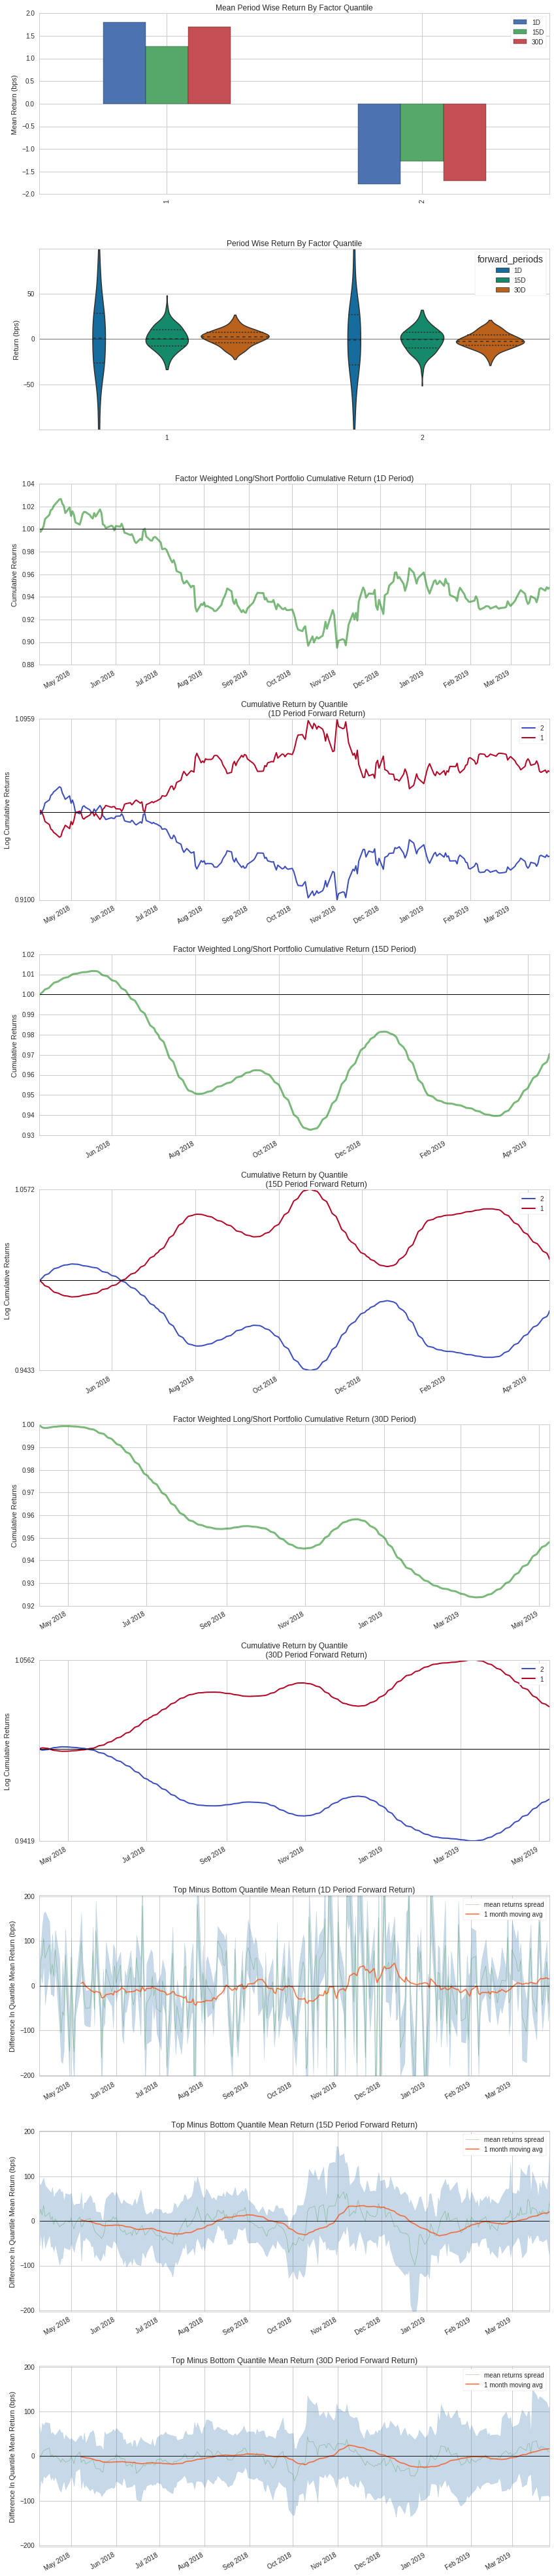

Information Analysis


,1D,15D,30D
IC Mean,-0.005,-0.033,-0.089
IC Std.,0.328,0.316,0.270
Risk-Adjusted IC,-0.016,-0.105,-0.329
t-stat(IC),-0.244,-1.644,-5.138
p-value(IC),0.808,0.101,0.000
IC Skew,-0.027,-0.147,0.169
IC Kurtosis,-0.752,-0.848,-0.462


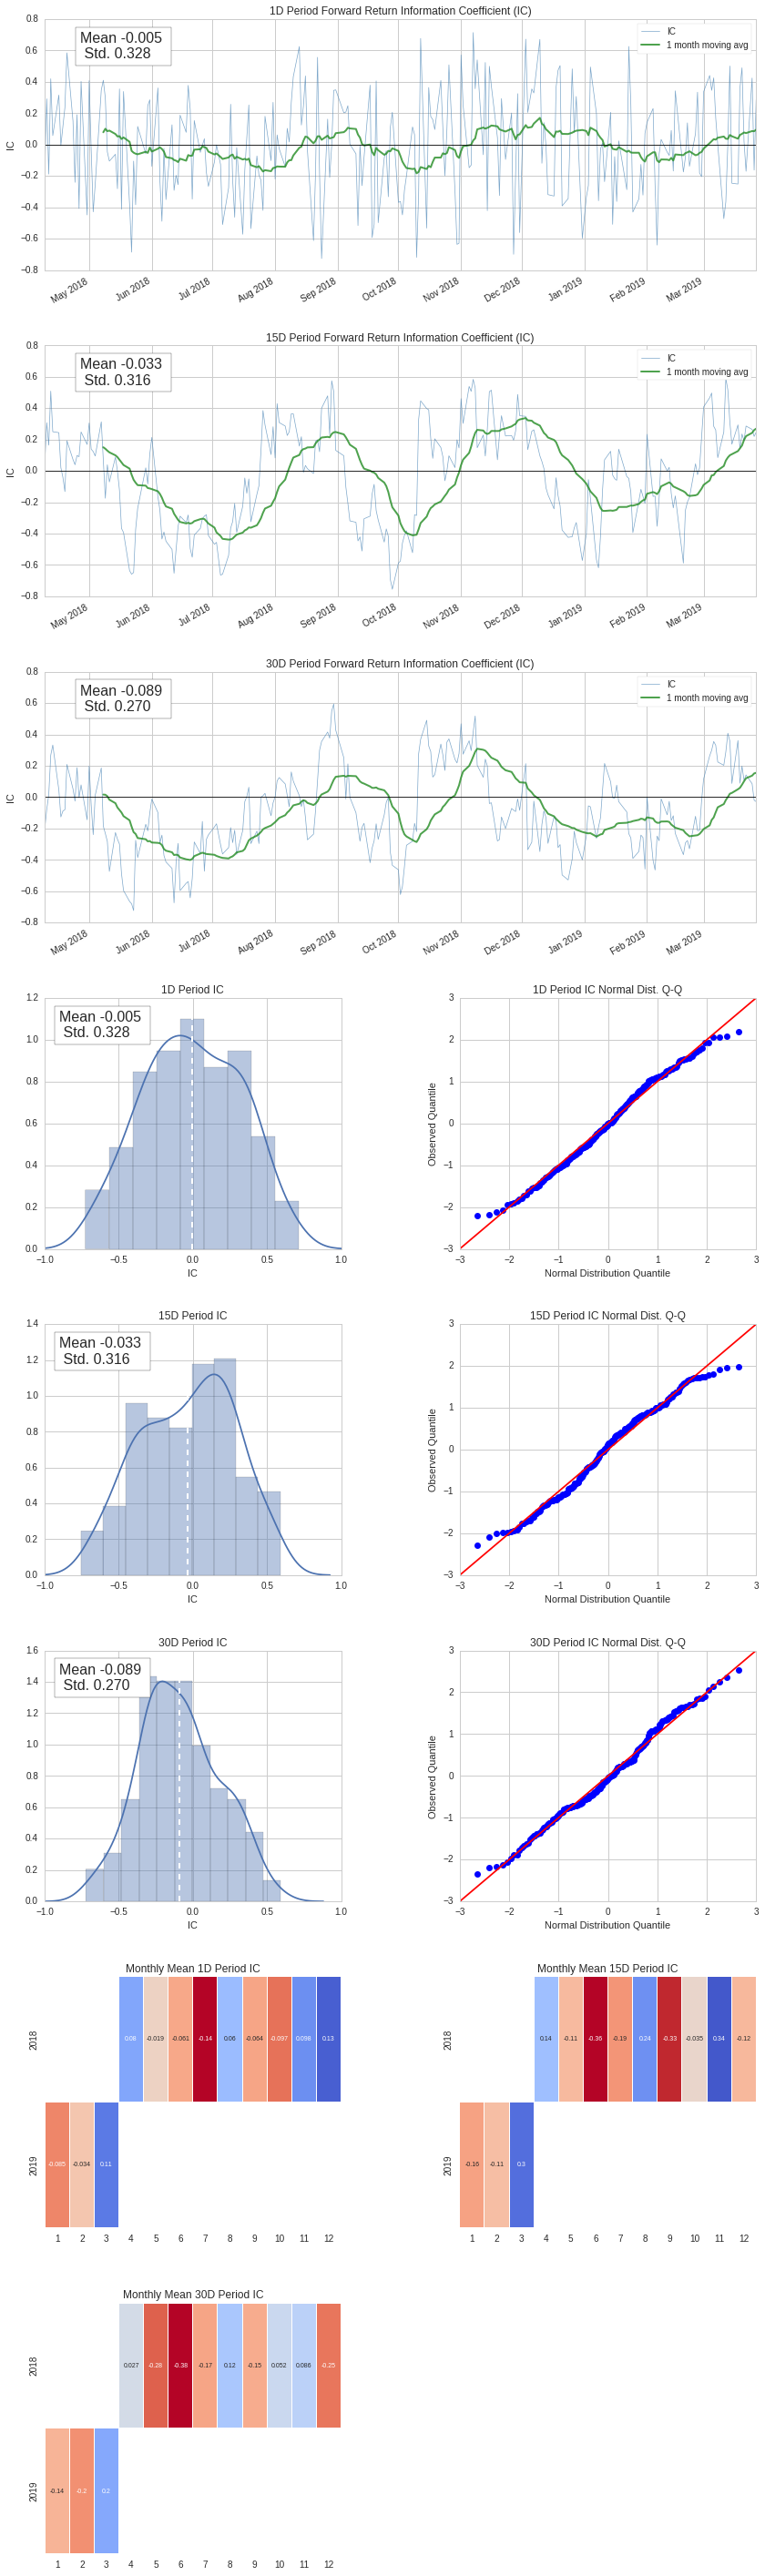

Turnover Analysis


,15D,1D,30D
Quantile 1 Mean Turnover,0.654,0.184,0.873
Quantile 2 Mean Turnover,0.692,0.200,0.913


,1D,15D,30D
Mean Factor Rank Autocorrelation,0.953,0.702,-0.135


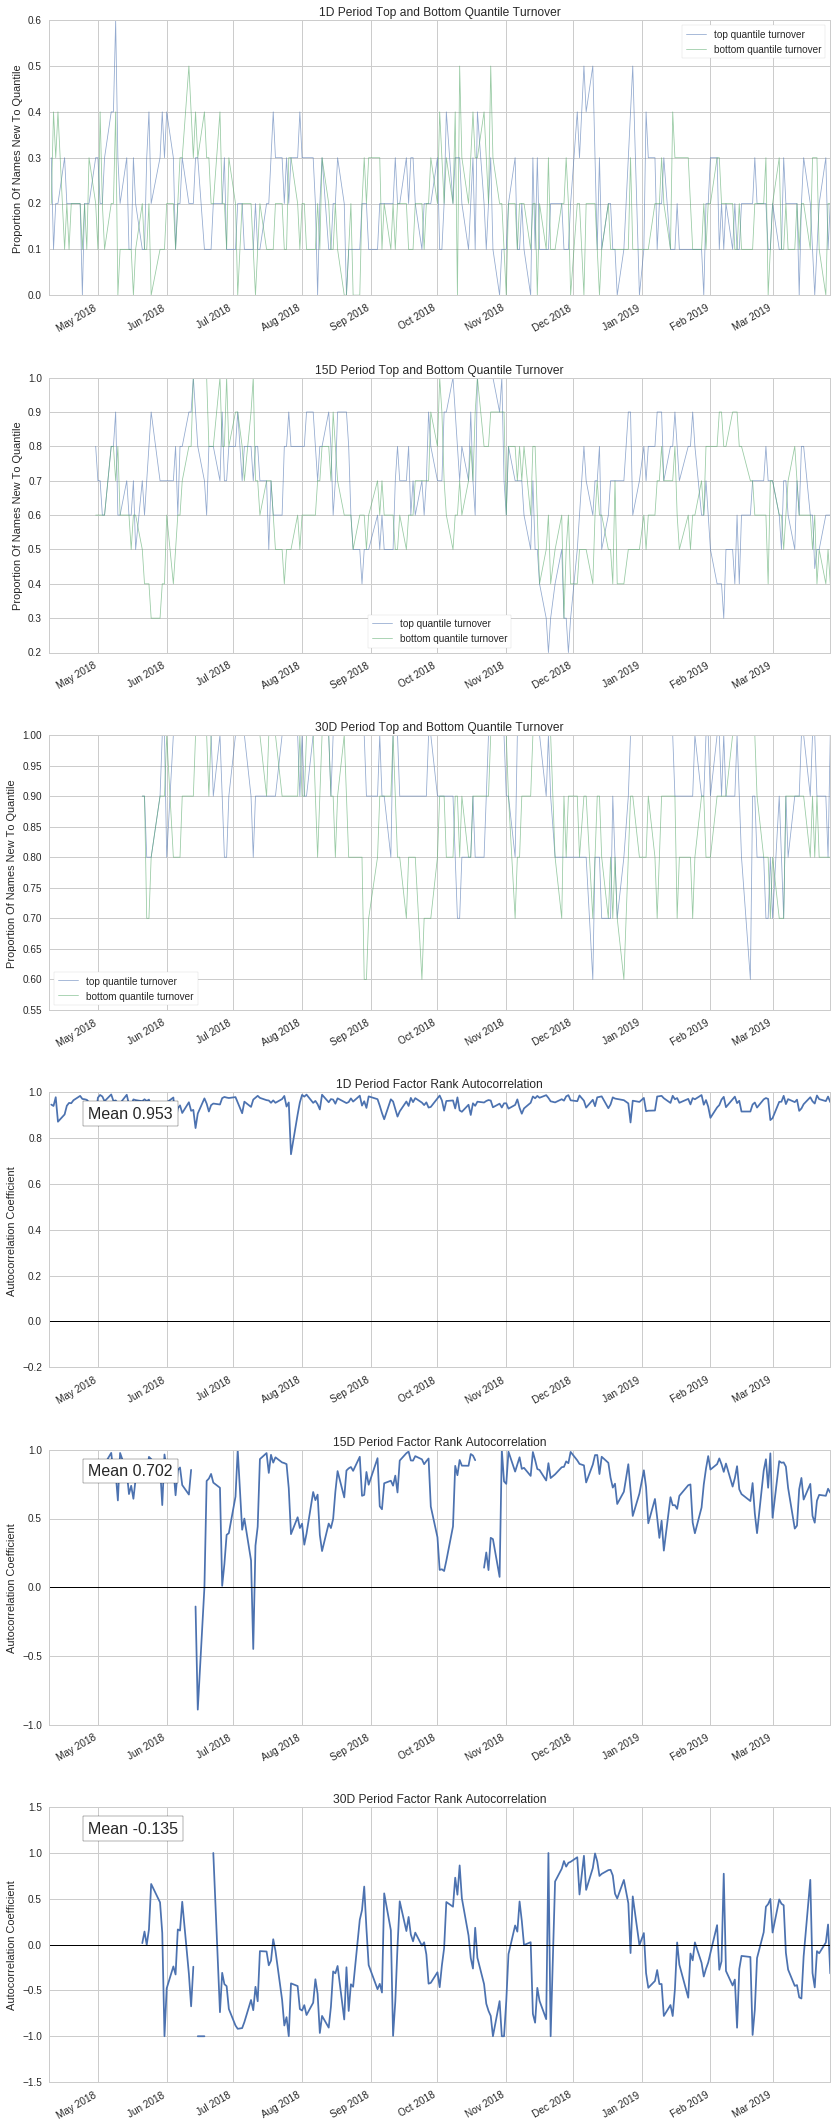

In [14]:
from alphalens.tears import create_full_tear_sheet

create_full_tear_sheet(merged_data)

In [160]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.filters import QTradableStocksUS
import quantopian.optimize as opt

def initialize(context):
    # Schedule our rebalance function to run at the start of
    # each week, when the market opens.
    schedule_function(
        my_rebalance,
        date_rules.week_start(),
        time_rules.market_open()
    )

    # Record variables at the end of each day.
    schedule_function(
        my_record_vars,
        date_rules.every_day(),
        time_rules.market_close()
    )

    # Create our pipeline and attach it to our algorithm.
    my_pipe = make_pipeline()
    attach_pipeline(my_pipe, 'my_pipeline')

def make_pipeline():
  
    # Base universe set to the QTradableStocksUS.
    base_universe = QTradableStocksUS()

    # 10-day close price average.
    mean_10 = SimpleMovingAverage(
        inputs=[USEquityPricing.close],
        window_length=10,
        mask=base_universe
    )

    # 30-day close price average.
    mean_30 = SimpleMovingAverage(
        inputs=[USEquityPricing.close],
        window_length=30,
        mask=base_universe
    )

    percent_difference = (mean_10 - mean_30) / mean_30

    # Filter to select securities to short.
    shorts = percent_difference.top(75)

    # Filter to select securities to long.
    longs = percent_difference.bottom(75)

    # Filter for all securities that we want to trade.
    securities_to_trade = (shorts | longs)

    return Pipeline(
        columns={
            'longs': longs,
            'shorts': shorts
        },
        screen=(securities_to_trade),
    )

def compute_target_weights(context, data):
   
    # Initialize empty target weights dictionary.
    # This will map securities to their target weight.
    weights = {}

    # If there are securities in our longs and shorts lists,
    # compute even target weights for each security.
    if context.longs and context.shorts:
        long_weight = 0.5 / len(context.longs)
        short_weight = -0.5 / len(context.shorts)
    else:
        return weights

    # Exit positions in our portfolio if they are not
    # in our longs or shorts lists.
    for security in context.portfolio.positions:
        if security not in context.longs and security not in context.shorts and data.can_trade(security):
            weights[security] = 0

    for security in context.longs:
        weights[security] = long_weight

    for security in context.shorts:
        weights[security] = short_weight

    return weights

def before_trading_start(context, data):
  

    # Gets our pipeline output every day.
    pipe_results = pipeline_output('my_pipeline')

    # Go long in securities for which the 'longs' value is True,
    # and check if they can be traded.
    context.longs = []
    for sec in pipe_results[pipe_results['longs']].index.tolist():
        if data.can_trade(sec):
            context.longs.append(sec)

    # Go short in securities for which the 'shorts' value is True,
    # and check if they can be traded.
    context.shorts = []
    for sec in pipe_results[pipe_results['shorts']].index.tolist():
        if data.can_trade(sec):
            context.shorts.append(sec)

def my_rebalance(context, data):
  
    # Calculate target weights to rebalance
    target_weights = compute_target_weights(context, data)

    # If we have target weights, rebalance our portfolio
    if target_weights:
        order_optimal_portfolio(
            objective=opt.TargetWeights(target_weights),
            constraints=[],
        )

def my_record_vars(context, data):
  
    longs = shorts = 0
    for position in context.portfolio.positions.itervalues():
        if position.amount > 0:
            longs += 1
        elif position.amount < 0:
            shorts += 1

    # Record our variables.
    record(
        leverage=context.account.leverage,
        long_count=longs,
        short_count=shorts
    )